# Introduction
The original project was done locally in a python notebook.  To improve upon this, I decided to move the project to google cloud.  

First, I loaded the data from my computer to Google Cloud Storage, then to Bigquery, and finally to Datalab.  Datalab is built upon the python notebook and has many scientific libraries preinstalled.

There were both advantages and disadvantages of doing the project on google cloud.  The code that I used to fill in the missing values in my numeric columns gave me an error on the cloud while it worked fine locally.  I changed the code to fix this error, however the changes altered the results.  The accuracy of the Logistic Regression increased, while the Adaboost decreased.

On the other hand, there was a massive improvement in speed going to the cloud.  When I ran this code locally, it took me around 4 hours.  But when I ran it on the cloud, it would finish in under an hour.


Logistic Regression: 0.8824979457682827
Random Forest: 0.8567515749109833
Gradient Boosting: 0.8742810188989318
AdaBoost: 0.8937277458230621


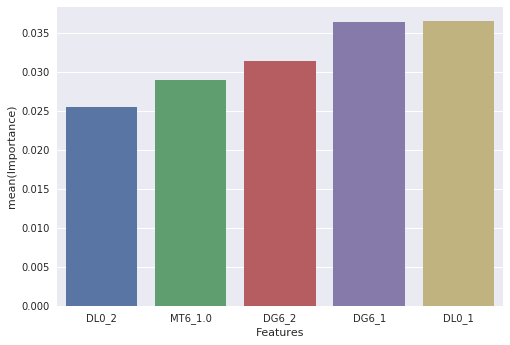

In [7]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sn

query_data = bq.Query('SELECT * FROM `widstrain1.train1`')
df = query_data.execute(output_options=bq.QueryOutput.dataframe()).result()

Y = df['is_female']
X = df.drop(['is_female','train_id'], axis = 1)
X = X.dropna(axis=1, thresh=20) 

categoricColumns = X.columns.tolist()
numericColumns = []

for i in categoricColumns:
    if ("MT17_" in i or "FF16_" in i or "MM5_" in i or "FF9" in i
         or "MM8_" in i or "MM9_" in i or "MM17_" in i or "MM32_" in i
         or "MM42_" in i or "MMP2_" in i or "MMP4_" in i or "IFI4_" in i
         or "IFI2_" in i or "IFI14_" in i or "IFI15_" in i or "IFI17_" in i
         or "FL3" in i or "FL8_" in i or "LN1A" in i or "LN1B" in i
         or "LN2_1" in i or "LN2_2" in i or "LN2_3" in i or "LN2_4" in i):
        numericColumns.append(i)
        categoricColumns.remove(i)

for i in numericColumns:
    median = X[i].median()
    X[i] = X[i].fillna(median) 

for i in categoricColumns:
    X[i] = X[i].fillna(0) 
    X = pd.get_dummies(X, columns=[i])
    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

# Logistic Regression
LogReg = linear_model.LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print('Logistic Regression: '+str(accuracy_score(y_test, y_pred)))

# Random Forest
clf = RandomForestClassifier(n_jobs=2, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Random Forest: '+str(accuracy_score(y_test, y_pred)))

# Gradient Boosting
clf = GradientBoostingClassifier(n_estimators=5000,
                                 learning_rate=0.5,
                                 max_depth=None, 
                                 random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Gradient Boosting: '+str(accuracy_score(y_test, y_pred)))

# AdaBoost
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=1000,
                         learning_rate=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('AdaBoost: '+str(accuracy_score(y_test, y_pred)))

# Feature importance
model = ExtraTreesClassifier()
model.fit(X, Y)

# display the relative importance of each attribute
impDf = pd.DataFrame(X.columns)
impDf = impDf.rename(columns={0: 'Features'})
impDf['Importance'] = model.feature_importances_
impDf = impDf.sort_values('Importance')
sn.barplot(x='Features', y='Importance', data=impDf[-5:])
plt.show()

## Conclusion
In order to determine which factors were most impactful in predicting genders, I used feature importance based on decision trees.  Here, the model creates decision trees with and without each feature.  Important factors will have a greater loss in accuracy when taken away from the decision tree, so larger importance values mean greater impact in predicting genders.

Looking at the importance chart, our top 5 factors are all categoric.  We created dummy variables for our categoric factors. 
For example, DG6 has 9 categoric values, so there will be dummy columns created for each of the 9 values (from DG6_1 to DG6_9).  DG6_1 will consist of 1’s when the row matches the first categoric value and 0’s for everything else.  The "DG6" refers to the question while the "1" refers to the answer.

DL0_1 and DL0_2 suggests that the main income earner in the household tend to be men, while someone who isn’t the main income earner tends to be women.

DG6_1 and DG6_2 suggests that respondents that are the head of the household tend to be men while respondents that are the spouse of the head of the household tend to be women.

MT6_1 suggests that respondents who obtained their own phone by themselves tend to be men.
